In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

In [ ]:
# Load the dataset
df = pd.read_csv('data.csv', delimiter=';')

In [ ]:
# Data Exploration Visualizations
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (4424, 37)

First 5 rows:
   Marital status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   

   Daytime/evening attendance\t  Previous qualification  \
0                             1                       1   
1                             1                       1   
2                             1                       1   
3                             1                       1   
4                             0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   
1                           160.0            1             

<ipython-input-5-dbad7f566aef>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Target', data=df, palette='viridis')


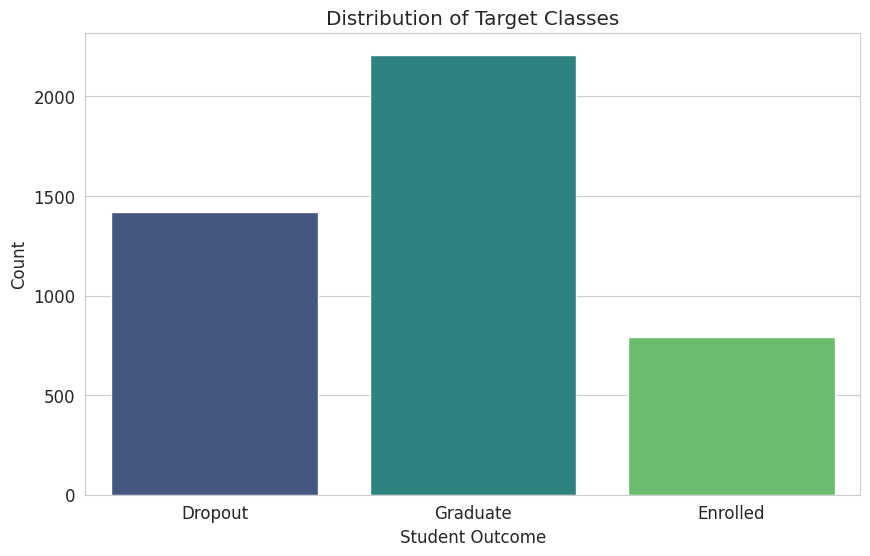

In [ ]:
# Target variable distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Target', data=df, palette='viridis')
plt.title('Distribution of Target Classes')
plt.xlabel('Student Outcome')
plt.ylabel('Count')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


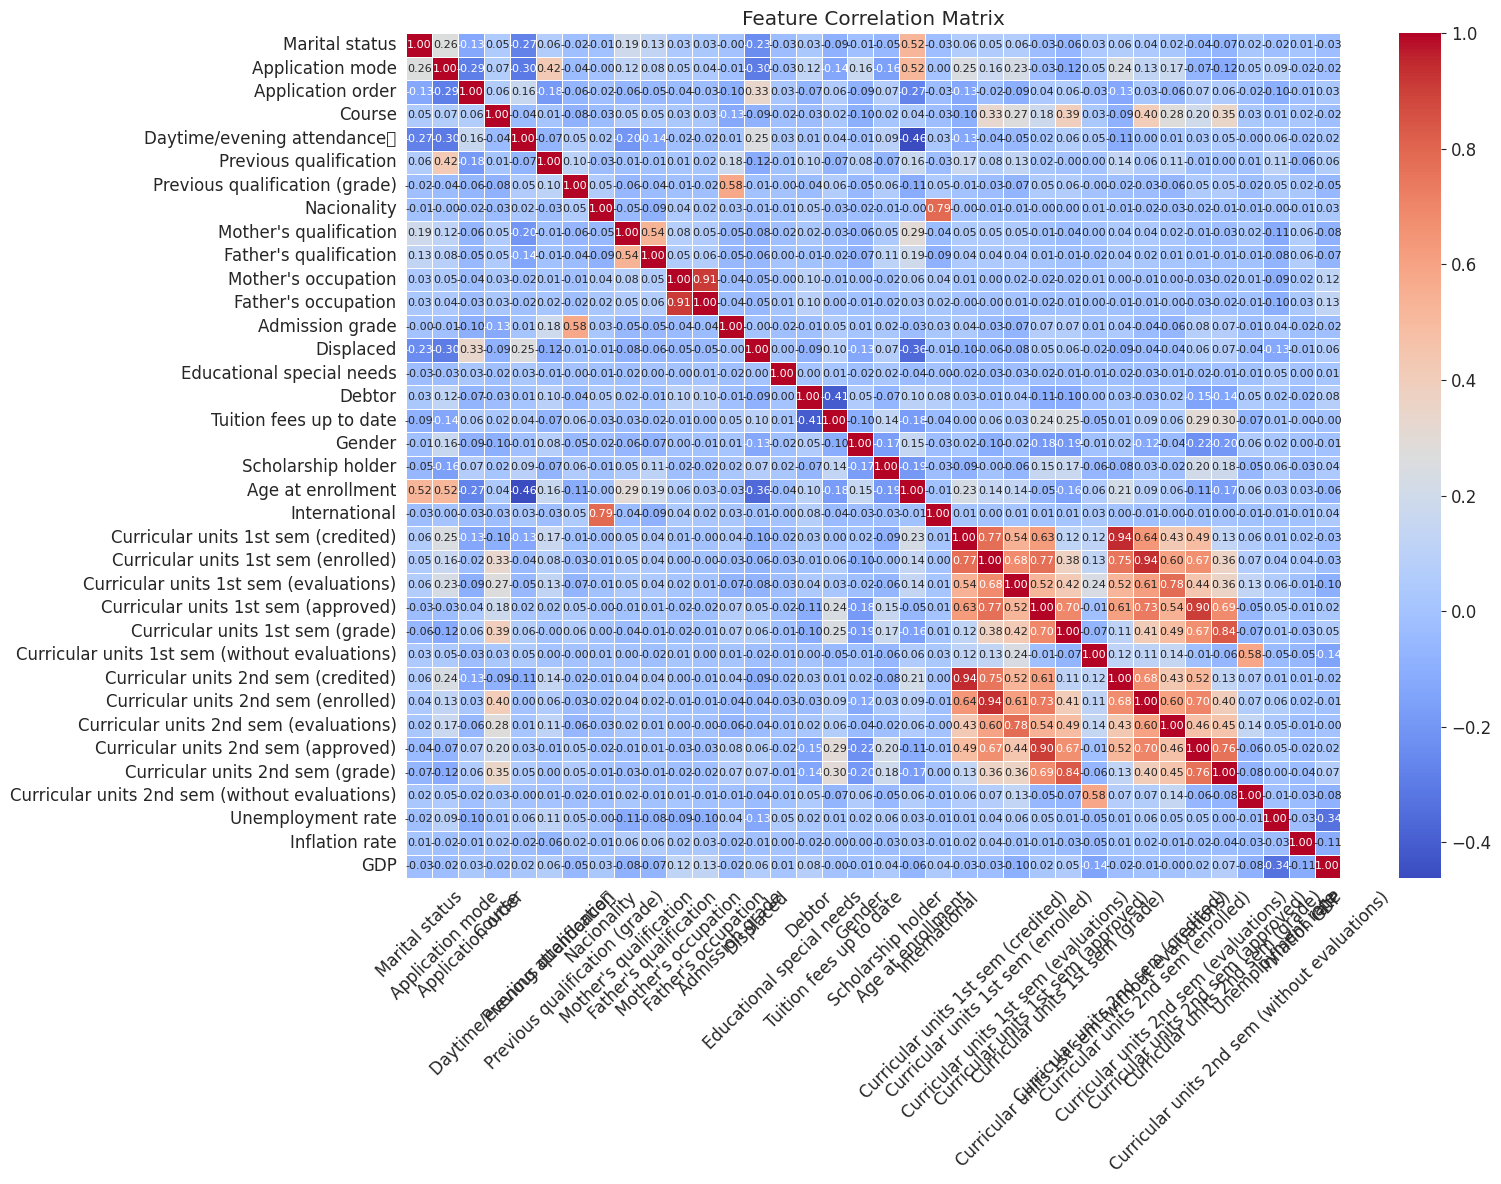

In [ ]:
# Correlation matrix
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(16, 12))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm',
            annot_kws={'size': 8}, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Data Preprocessing
# Drop columns with too many missing values or irrelevant for prediction
df = df.drop(['Curricular units 1st sem (without evaluations)',
              'Curricular units 2nd sem (without evaluations)'], axis=1)

In [ ]:
# Handle missing values
df = df.dropna()

In [ ]:
# Encode categorical variables
label_encoder = LabelEncoder()
df['Target'] = label_encoder.fit_transform(df['Target'])

In [ ]:
# Feature selection - selecting relevant features based on domain knowledge
features = ['Marital status', 'Application mode', 'Application order',
            'Previous qualification (grade)', 'Admission grade',
            'Tuition fees up to date', 'Gender', 'Scholarship holder',
            'Age at enrollment', 'Curricular units 1st sem (credited)',
            'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)',
            'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)',
            'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)',
            'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)',
            'Curricular units 2nd sem (grade)', 'Unemployment rate', 'Inflation rate', 'GDP']

X = df[features]
y = df['Target']

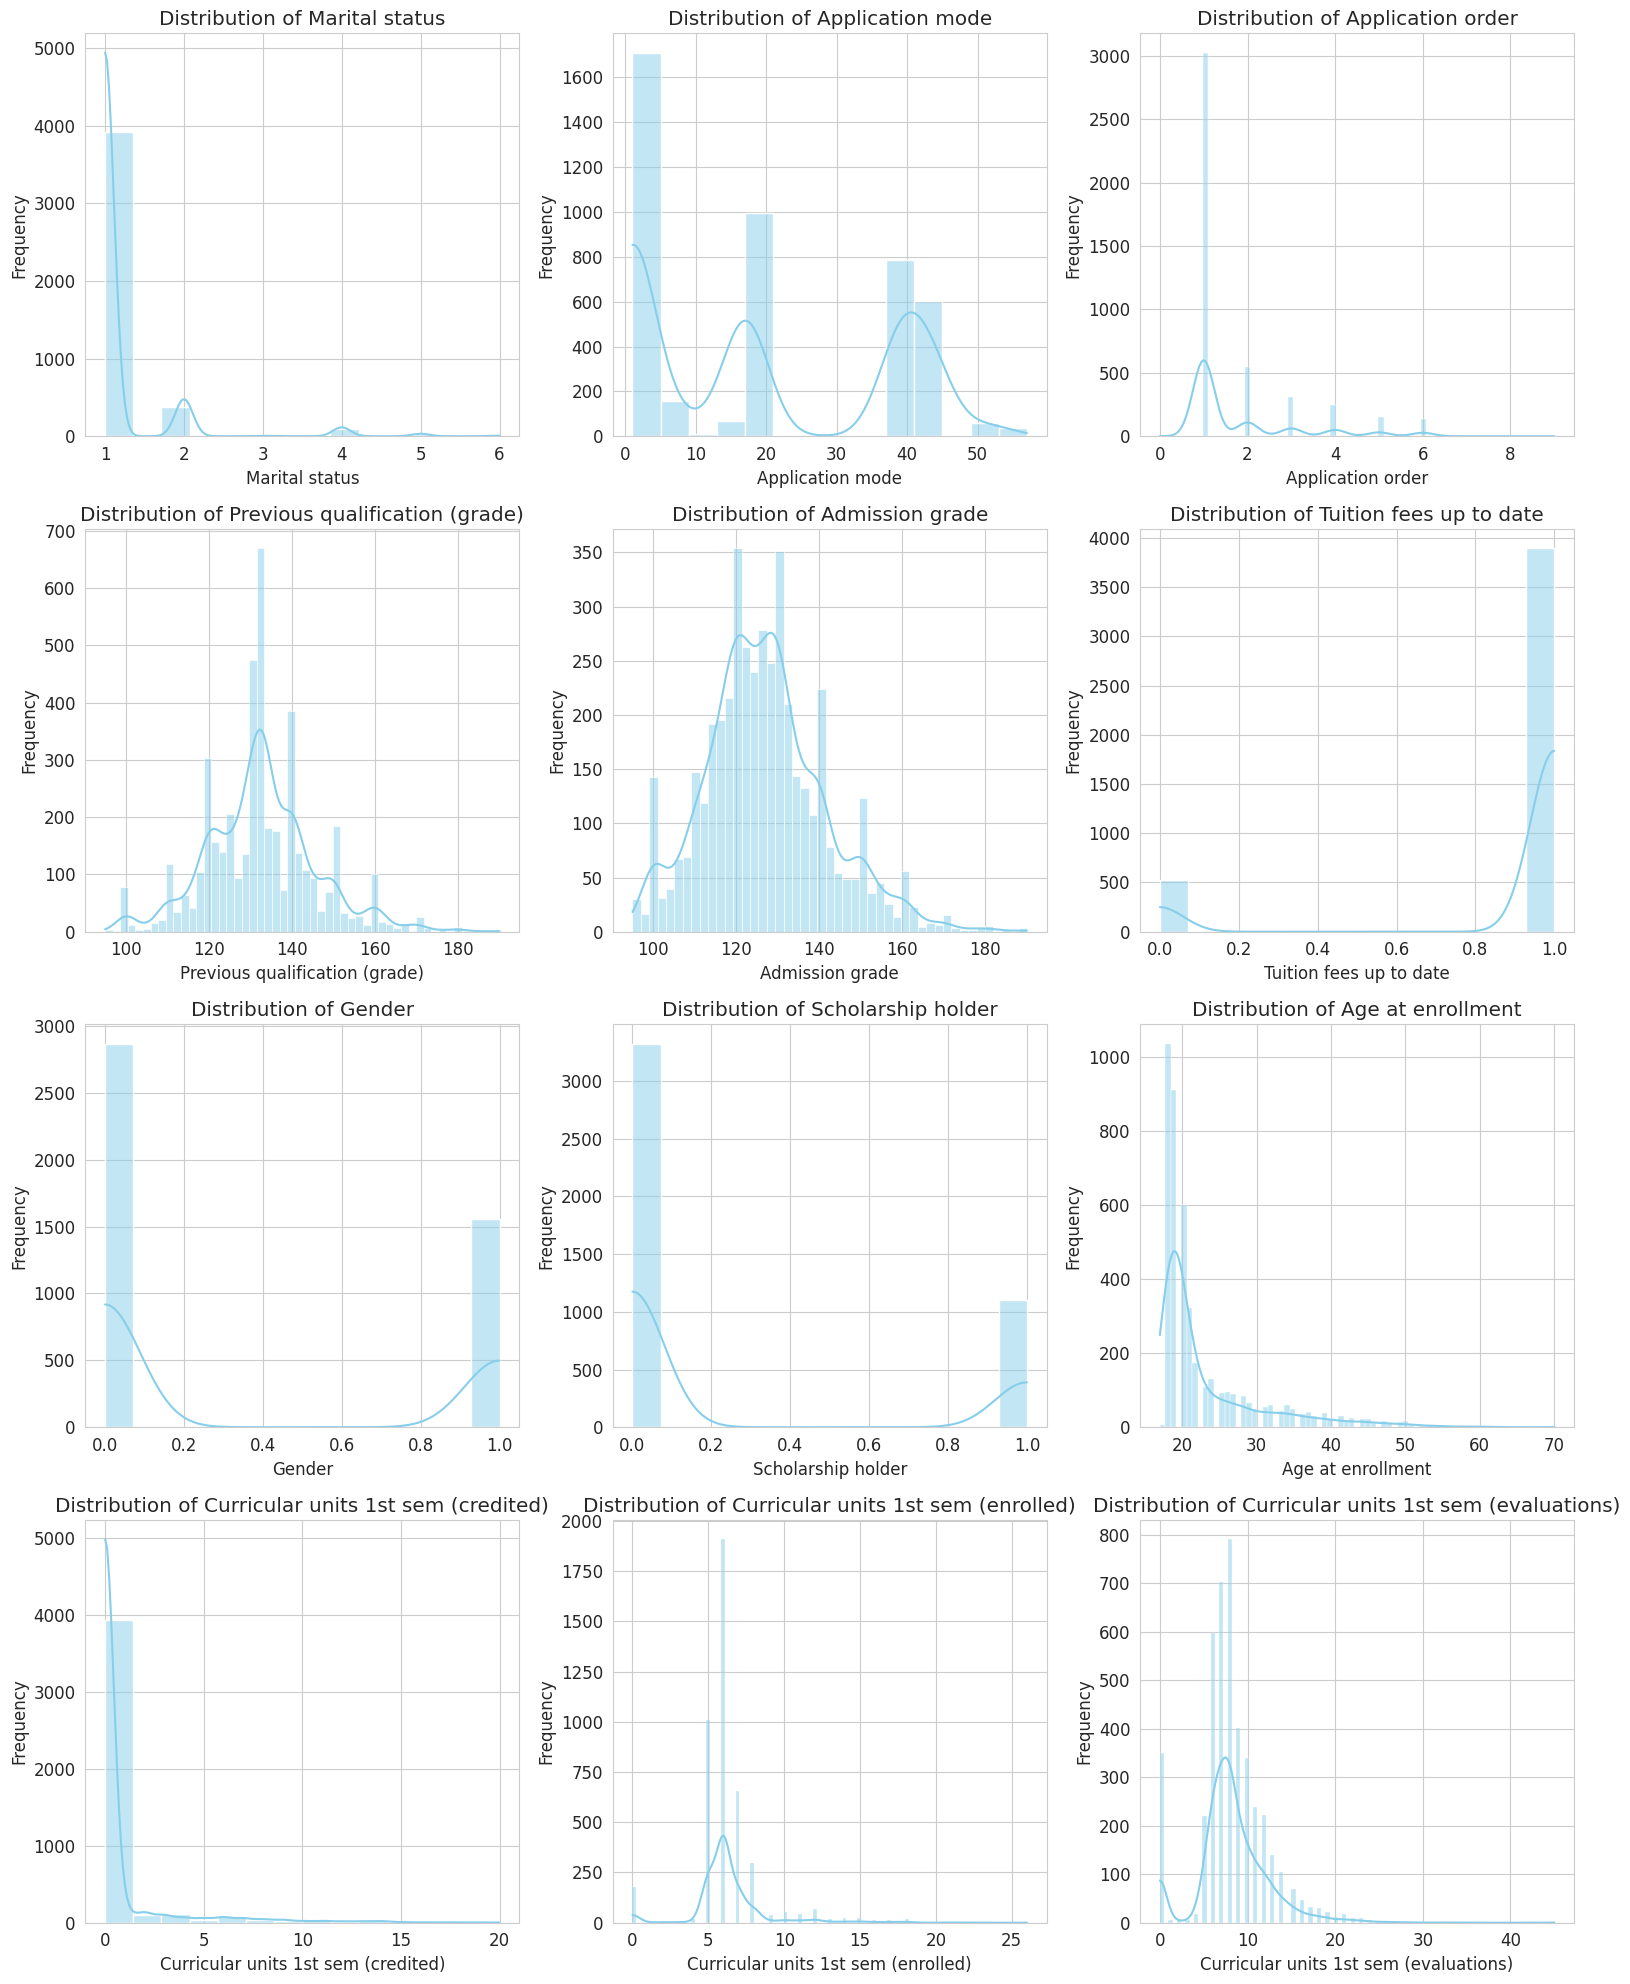

In [ ]:
# Visualize feature distributions
plt.figure(figsize=(16, 20))
for i, col in enumerate(features[:12]):  # Show first 12 features
    plt.subplot(4, 3, i+1)
    sns.histplot(X[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Show class distribution before SMOTE
print("\nClass distribution before SMOTE:", Counter(y_train))


Class distribution before SMOTE: Counter({2: 1767, 0: 1137, 1: 635})


In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
# Show class distribution after SMOTE
print("Class distribution after SMOTE:", Counter(y_train_res))

Class distribution after SMOTE: Counter({2: 1767, 0: 1767, 1: 1767})


In [ ]:
# PCA Visualization for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

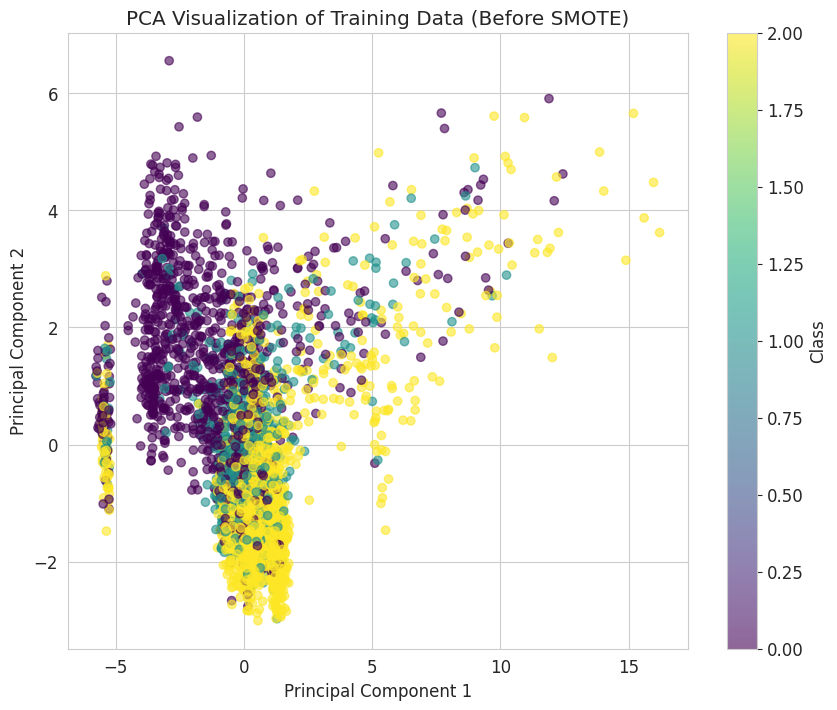

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.title('PCA Visualization of Training Data (Before SMOTE)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Class')
plt.show()

In [ ]:
# Build the deep learning model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(3, activation='softmax')  # 3 output classes
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(X_train_res, y_train_res,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7621 - loss: 0.5912 - val_accuracy: 0.7119 - val_loss: 0.6519
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7559 - loss: 0.5981 - val_accuracy: 0.7062 - val_loss: 0.6512
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7610 - loss: 0.5815 - val_accuracy: 0.7209 - val_loss: 0.6484
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7698 - loss: 0.5850 - val_accuracy: 0.7096 - val_loss: 0.6574
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7575 - loss: 0.6017 - val_accuracy: 0.6938 - val_loss: 0.6825
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7625 - loss: 0.5732 - val_accuracy: 0.7164 - val_loss: 0.6618
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7637 - loss: 0.5831 - val_accuracy: 0.7130 - val_loss: 0.6779
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7776 - loss: 0.5627 - val_accuracy: 0.

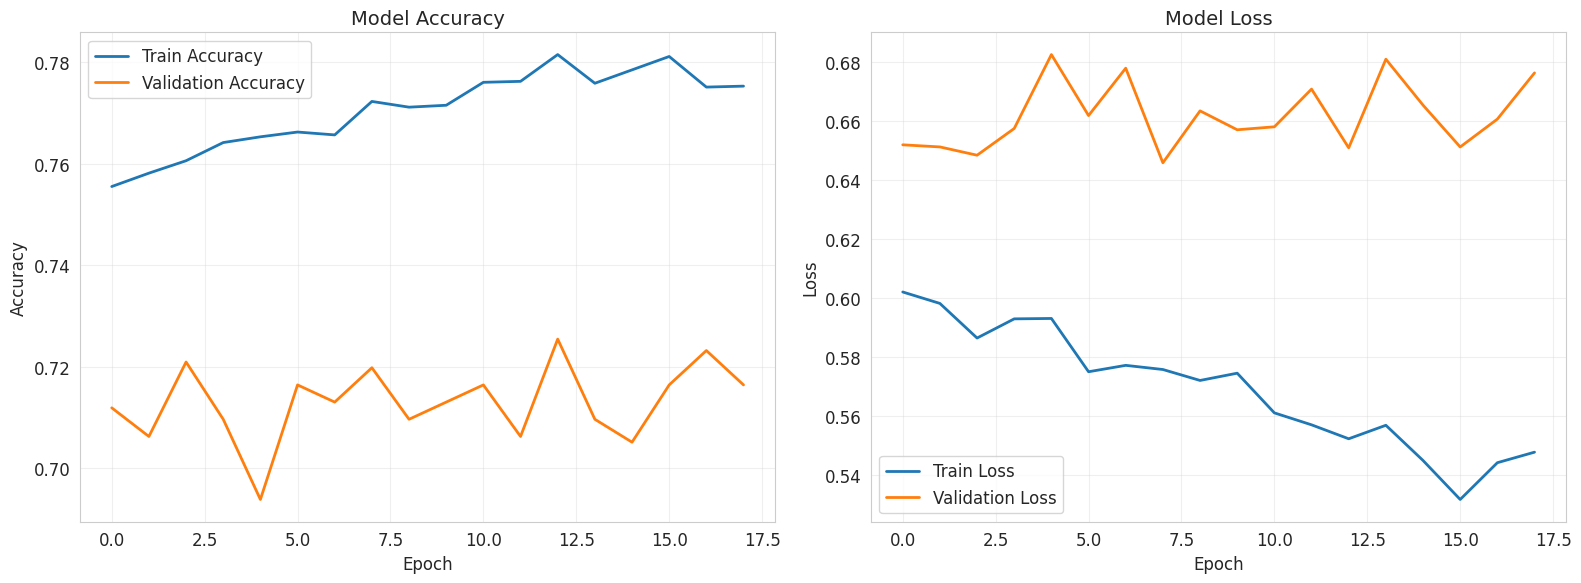

In [ ]:
# Plot training history
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [ ]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes,
                           target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

     Dropout       0.86      0.67      0.75       284
    Enrolled       0.40      0.63      0.49       159
    Graduate       0.84      0.78      0.81       442

    accuracy                           0.72       885
   macro avg       0.70      0.69      0.68       885
weighted avg       0.77      0.72      0.73       885



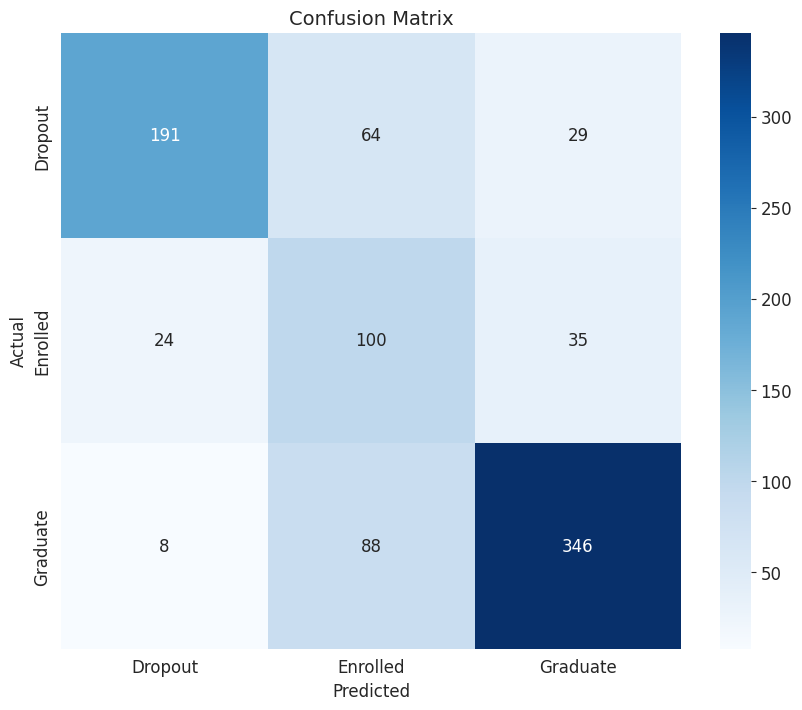

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

In [ ]:
# ROC Curve (One-vs-Rest)
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']

<Figure size 1000x800 with 0 Axes>

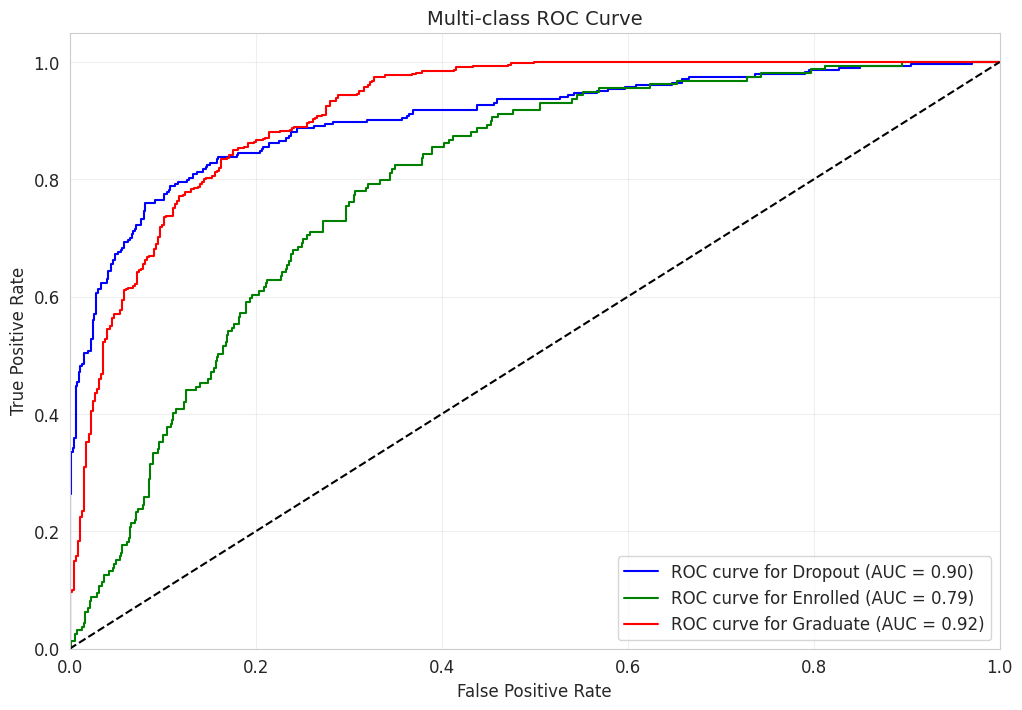

In [ ]:
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test, y_pred[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i],
             label=f'ROC curve for {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Feature Importance Analysis (using permutation importance)
from sklearn.inspection import permutation_importance

def model_score(estimator, X, y): # Add estimator as argument
    y_pred = estimator.predict(X)  # Use estimator for prediction
    y_pred_classes = np.argmax(y_pred, axis=1)
    return accuracy_score(y, y_pred_classes)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━

<ipython-input-38-1152ce35f282>:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T,


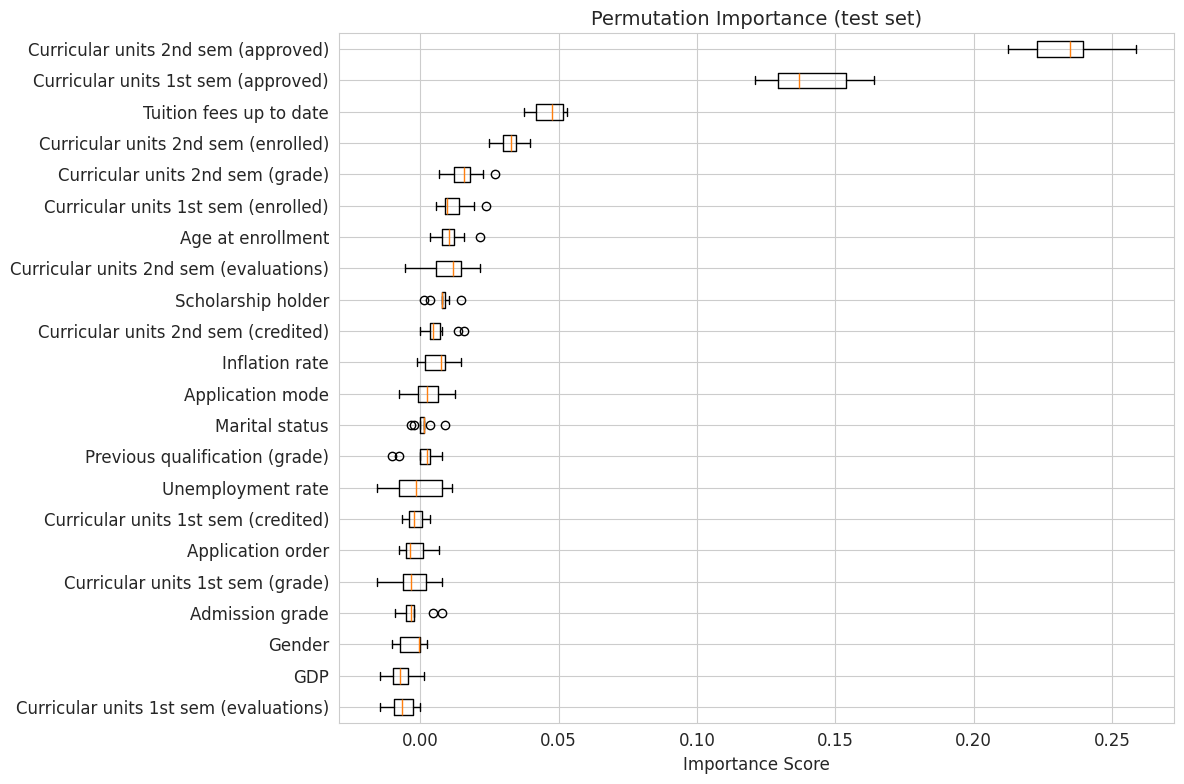

In [ ]:
# Now use the scoring function with permutation_importance
result = permutation_importance(model, X_test_scaled, y_test,
                                scoring=model_score,  # Pass the scoring function
                                n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(12, 8))
plt.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.array(features)[sorted_idx])
plt.title("Permutation Importance (test set)", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.tight_layout()
plt.show()

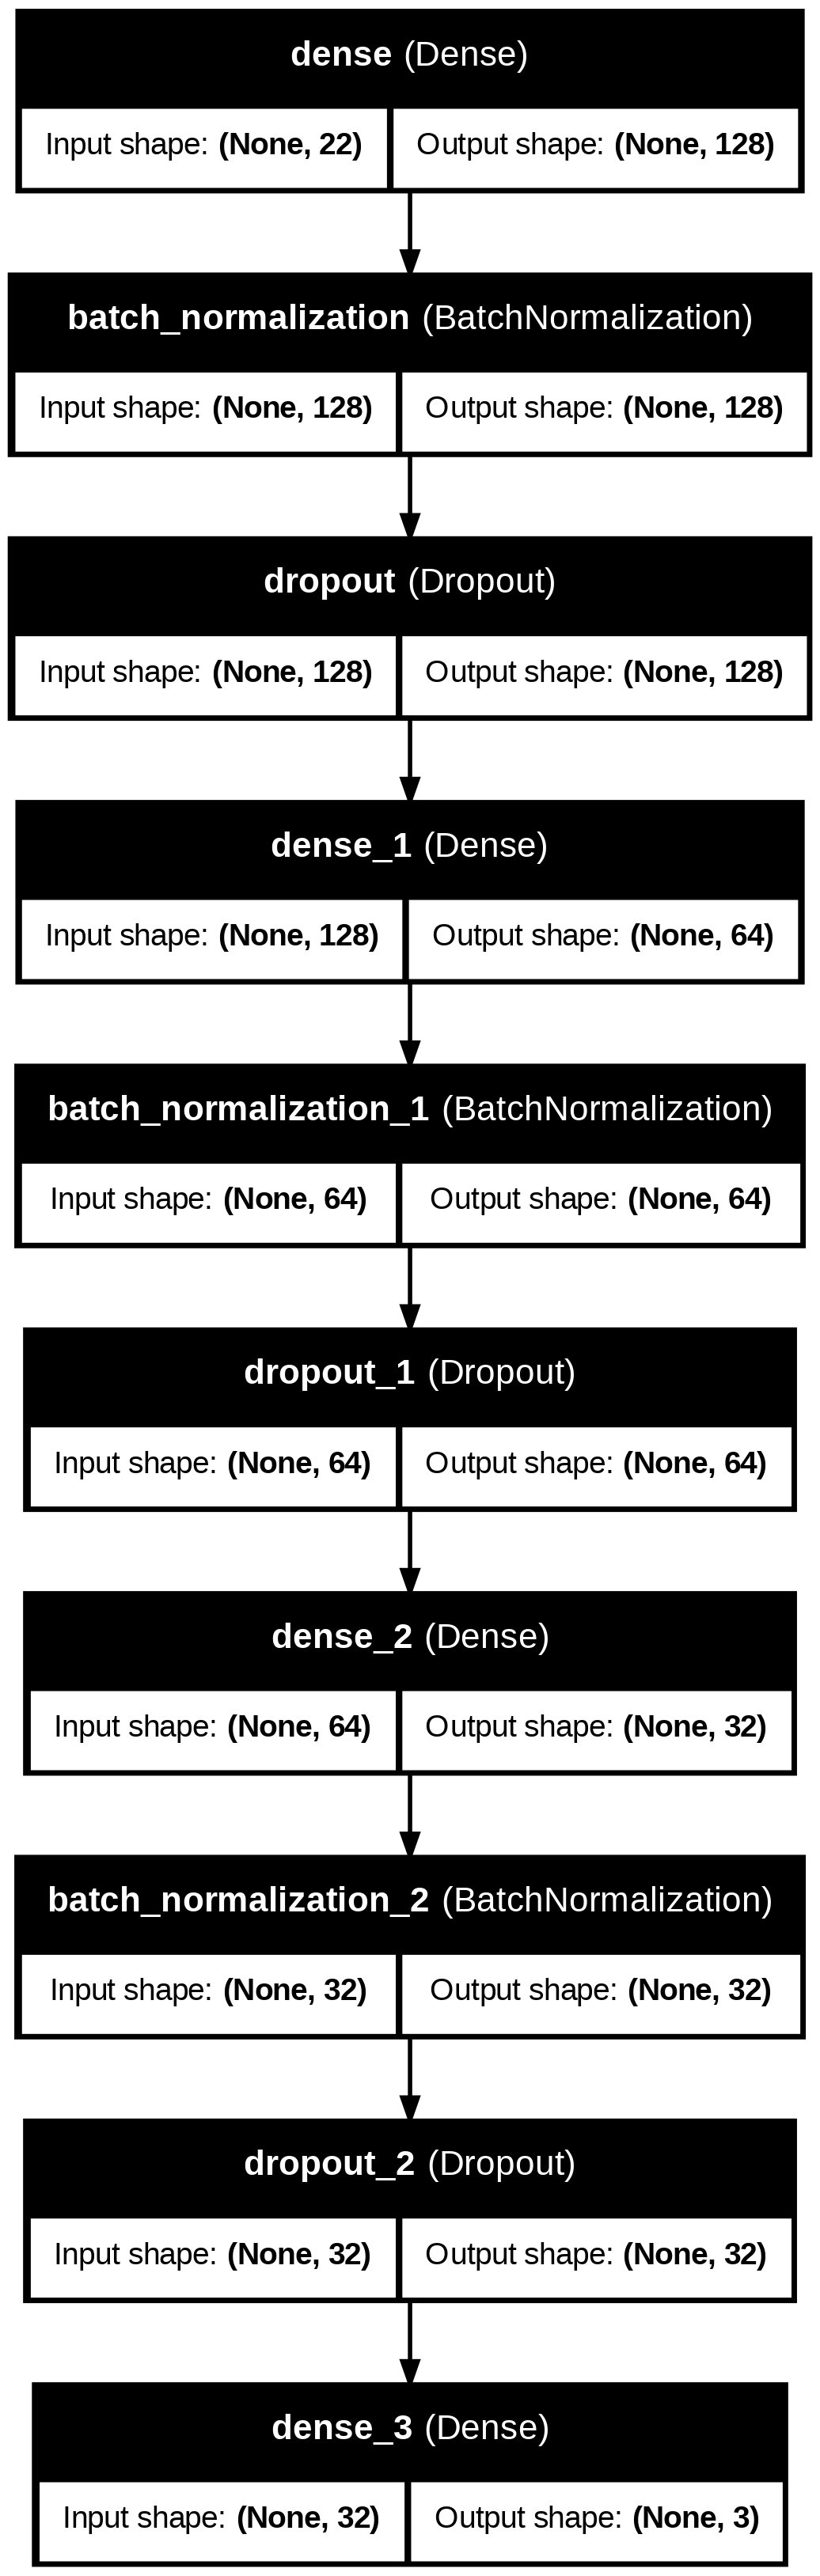

In [ ]:
# Visualize model architecture
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)